<a href="https://colab.research.google.com/github/VU-CSP/popgrowth_assignment-Sabinaleonard/blob/main/PopGrowthLecture_assignment_SL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Cell Proliferation
## Objectives
This notebook has sections designed to:
1) Provide background on cell proliferation  
2) Describe basic mathematical models of population growth  
3) Analyze dynamic cell count data  
4) Perform linear and nonlinear regression of models fit to cell count data  
5) Create functions in Python to perform calcuations 

## Cell proliferation
### Nomenclature
* _Growth_ can mean an increase in mass or volume (at the individual level)
* _Growth_ can also indicate an increase in population size (e.g. the number of cells in a tumor)
* _Proliferation_ generally refers to change in the number of individuals within a group (e.g. exponential population growth)
* _Tumor growth_ generally refers to the size of the tumor, but an increase in the number of tumor cells is implicit

### Typical assays of proliferation, survival and death
* Usually performed to test effects of perturbation (e.g. a drug)  
* Most are static assays (take a snapshot)  
* Multiple measurements require multiple samples (since they are destructive)  
* Typically reported as fraction of control or percent change (relative, not absolute metrics)  
* Biomarkers of the processes that change cell population size  

Images below are representatives of 1) fluorescence microscopy of calcein/propidium iodide stained cells, 2) flow cytometry of cells stained with FxCycle violet and phospho-histone H3, 3) fluorescence microscopy of annexin A5-fluorescein-stained cells and 4) fluorescence microscopy of cells after addition of caspase 3 substrate that becomes fluorogenic upon cleavage by caspase 3 (pink).  



<table>
    <tr>
      <td>
      <img src="https://github.com/VU-CSP/quantbio-assignments/blob/main/img/calcein-PI.png?raw=1" style="width: 200px;" />
      </td>
      <td>
      <img src="https://github.com/VU-CSP/quantbio-assignments/blob/main/img/flow-mitosis.png?raw=1" style="width: 200px;" />
      </td>
      <td>
      <img src="https://github.com/VU-CSP/quantbio-assignments/blob/main/img/Anx5.png?raw=1" style="width: 200px;" />
      </td>
      <td>
      <img src="https://github.com/VU-CSP/quantbio-assignments/blob/main/img/activeCasp3.png?raw=1" style="width: 200px;" />
      </td>
     </tr>
</table>

### Exponential growth
#### _A math refresher_
<img src="https://github.com/VU-CSP/quantbio-assignments/blob/main/img/Math-ugh.png?raw=1" style="width: 500px;"/>

* Definition of Logarithm: $log_e e^x = x$, where $e > 0$ and $e ≠ 1$   
* Product Rule: $log(xy) = log(x) + log(y)$
* Base change rule: $log_a(n) = log_b(n)/log_a(b)$  

#### **Exponential growth equation**
$P(t) = P_0e^{at}$, where  
$P(t)$ is the population size at time = $t$,  
$P_0$ is initial population size, and  
$a$ is the growth rate constant.

_The logarithm of the growth equation is linear_  
$log_e P(t) = log_e P_0e^{at} = log_e P_0 + log_e e^{at} = log_e P_0 + at$  

_(reorganizing to the form of $y = ax + b$)_  
$log_e P(t) = at + log_e P_0$, where,  
growth rate = $a$ = _slope of the line_ and log of initial population size = _y intercept_   

##### **This means that you can fit exponentially growing population data with linear models**

This also works in log2 scale using a population doubling function:  
$P(t) = P_02^{at}$,  
which allows for an easier biological interpretation.

## Plotting and interpreting cell population growth data
These graphs were previously generated and are shown for reference. Data are shown in linear, log2 and normalized log2 scales. Lines shown on log2 and normalized log2 plots represent linear model fits and the slope (proliferation rate) and doubling time (1/proliferation rate) parameters of the optimal model fit are shown.  

<img src="https://github.com/VU-CSP/quantbio-assignments/blob/main/img/pop_growth_difft_scales.png?raw=1" style="width: 800px;" />


### Divergence from exponential growth
There are numerous conditions that result in non-exponential cell population growth, for example, when cells fill in their available space (a.k.a. contact inhibition).  


<img src="https://github.com/VU-CSP/quantbio-assignments/blob/main/img/contact_inhibition.png?raw=1" style="width: 300px;"/>  

There are some specific models that have been used to model growth inhibition, including the 
**Logistic** and **Gompertz** functions.  


<img src="https://github.com/VU-CSP/quantbio-assignments/blob/main/img/evidence_for_Gompertz_tumors.png?raw=1" style="width: 800px;"/>  
<img src="https://github.com/VU-CSP/quantbio-assignments/blob/main/img/logistic_growth_model.jpeg?raw=1" style="width: 800px;"/>  
<img src="https://github.com/VU-CSP/quantbio-assignments/blob/main/img/gompertz_growth_model.jpeg?raw=1" style="width: 800px;"/>  


_We will do some exploratory data analysis of a small cell count data set to interpret how populations of cells grow in culture._
-----

### First, import necessary Python packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

See whether we are running in Google Colab or not.

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

### Load custom functions
File name `growth_fxns.py` includes functions for:  
* flattening a matrix (nested lists): `flatten_matrix`  
* stochastic simulation of exponential growth: `gillespie_growth`  
* deterministic solution of exponential growth: `exp_growth`  
    
* deterministic solution of logistic growth: `mylogistic`
* deterministic solution of Gompertzian growth: `gompertz`


In [3]:
if IN_COLAB and not os.path.exists("growth_fxns.py"):
    !wget "https://raw.githubusercontent.com/VU-CSP/quantbio-assignments/main/growth_fxns.py"
from growth_fxns import *

### Adjust seaborn plot settings
_To make the graphics prettier._ You can learn more about seaborn at the [seaborn website]()  

In [4]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#### Load a small dataset
Data from multiwell plate of cells, some of which have been treated with a drug.

In [5]:
if IN_COLAB and not os.path.exists("MCF10A_trametinib.csv"):
    !wget "https://raw.githubusercontent.com/VU-CSP/quantbio-assignments/main/MCF10A_trametinib.csv"
d = pd.read_csv("MCF10A_trametinib.csv")
d.head()

,well,time,cell.count,uid,drug1,drug1.conc
0,A01,0.8,32,10ACh-28A_H03,trametinib,0.000004
1,A01,5.6,25,10ACh-28A_H03,trametinib,0.000004
2,A01,10.5,31,10ACh-28A_H03,trametinib,0.000004
3,A01,15.3,53,10ACh-28A_H03,trametinib,0.000004
4,A01,20.0,39,10ACh-28A_H03,trametinib,0.000004


### Add new columns
Add values for log2(cell.count) (`l2`) and population doublings (`pd`). Calculating log2 values are easy since it is calculated directly from the `cell.count` values. Population doublings must be normalized for each well independently. To better understand each step, try to pull out the code in smaller chunks and run them in different cells.

In [6]:
d.insert(2,"l2",np.empty_like(d["cell.count"]))
d.insert(3,"pd",np.empty_like(d["cell.count"]))
d["l2"] = np.round(np.log2(d["cell.count"]),3)
d["pd"] = flatten_matrix([np.round(d[d["well"]==w]["l2"] - d[d["well"]==w]["l2"].to_list()[0],3) for w in d["well"].unique()])

In [7]:
d.head(30)

,well,time,l2,pd,cell.count,uid,drug1,drug1.conc
0,A01,0.8,5.000,0.000,32,10ACh-28A_H03,trametinib,0.000004
1,A01,5.6,4.644,-0.356,25,10ACh-28A_H03,trametinib,0.000004
2,A01,10.5,4.954,-0.046,31,10ACh-28A_H03,trametinib,0.000004
3,A01,15.3,5.728,0.728,53,10ACh-28A_H03,trametinib,0.000004
4,A01,20.0,5.285,0.285,39,10ACh-28A_H03,trametinib,0.000004
5,A01,24.8,5.700,0.700,52,10ACh-28A_H03,trametinib,0.000004
6,A01,29.6,5.615,0.615,49,10ACh-28A_H03,trametinib,0.000004
7,A01,34.4,5.807,0.807,56,10ACh-28A_H03,trametinib,0.000004
8,A01,39.2,5.781,0.781,55,10ACh-28A_H03,trametinib,0.000004
9,A01,44.0,5.700,0.700,52,10ACh-28A_H03,trametinib,0.000004


## Assignment task #1
Copy and execute a chunk of code from the line assigning values to `d["pd"]`. Describe what you did and the output in the following markup block.

In [8]:
# Add your code here
d["pd"] = flatten_matrix([np.round(d[d["well"]==w]["l2"] - d[d["well"]==w]["l2"].to_list()[0],3) for w in d["well"].unique()])

This code is calling a function previously defined in the file "growth_fxns.py" that flattens a matrix. This code is assigning values to the newly created column "pd".
The for loop (for w in d["well"]) locates the unique values in the "well" column and corresponding values in the "12" column". 
The np.round function rounds output to set # of decimal places (3). 

#### Plot data in different scales
We will look at a single well (`A02`) of data in linear scale (direct cell counts), log2 scale and as population doublings (log2 scale normalized to 1 cell at the first time point).

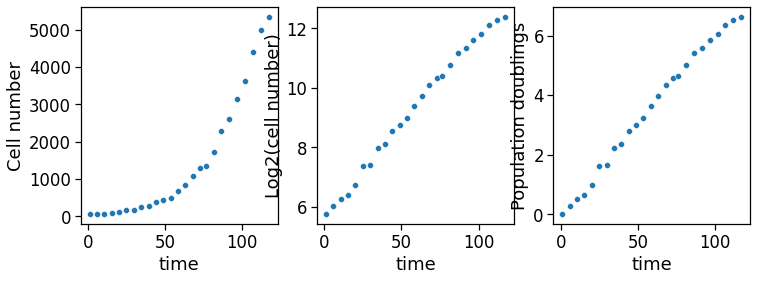

In [9]:
ss = d[d["well"]=="A02"]
# names = ['Linear', 'Log2', 'Normalized log2']
if IN_COLAB:
    fig, axs = plt.subplots(figsize=(12, 4))
else:
    fig, axs = plt.subplots(figsize=(12, 4), layout="constrained")
plt.subplot(131)
plt.ylabel('Cell number')
sns.scatterplot(data=ss, x="time", y="cell.count")
plt.subplot(132)
plt.ylabel('Log2(cell number)')
sns.scatterplot(data=ss, x="time", y="l2")
plt.subplot(133)
plt.ylabel('Population doublings')
sns.scatterplot(data=ss, x="time", y="pd")
plt.show()

#### Look at aggregated data
Many seaborn functions will automatically perform the statistical estimation. In the plots below, data will be grouped by `drug1` using the seaborn `hue` argument.

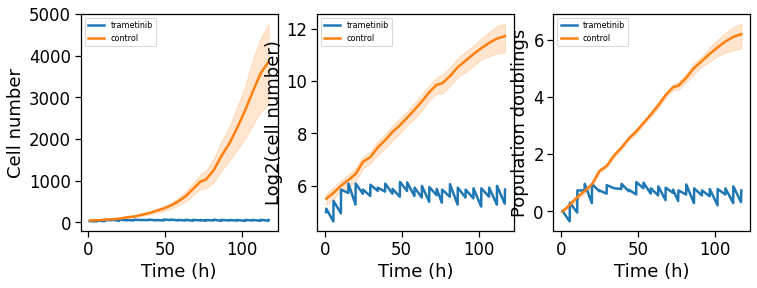

In [10]:
if IN_COLAB:
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
else:
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), layout="constrained")

plt.subplot(131)
plt.xlabel('Time (h)')
plt.ylabel('Cell number')
sns.lineplot(data=d, x="time", y="cell.count", hue="drug1")
plt.legend(loc='upper left', fontsize='8')
plt.subplot(132)
plt.xlabel('Time (h)')
plt.ylabel('Log2(cell number)')
sns.lineplot(data=d, x="time", y="l2", hue="drug1")
plt.legend(loc='upper left', fontsize='8')
plt.subplot(133)
plt.xlabel('Time (h)')
plt.ylabel('Population doublings')
sns.lineplot(data=d, x="time", y="pd", hue="drug1")
plt.legend(loc='upper left', fontsize='8')
plt.show()


The shaded areas represent confidence intervals. Compare the confidence interval between the log2 and normalized log2 plots, especially at time < 100 h.

How many samples of each type are there? Calculate this by counting the number of unique `well`s there are in each group (`drug1`==trametinib or control)

In [11]:
n_tram = len(d[d["drug1"]=="trametinib"]["well"].unique())
n_ctrl = len(d[d["drug1"]!="trametinib"]["well"].unique())

print(f"Wells with trametinib treatment: n = {n_tram}\nControl wells: n = {n_ctrl}")

Wells with trametinib treatment: n = 2
Control wells: n = 10


#### Look at data by well
To see each well of data individually we will set `hue` to color data by `well`.

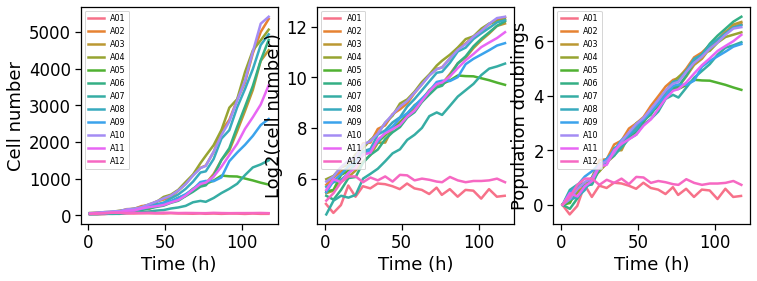

In [12]:
if IN_COLAB:
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
else:
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), layout="constrained")
plt.subplot(131)
plt.xlabel('Time (h)')
plt.ylabel('Cell number')
sns.lineplot(data=d, x="time", y="cell.count", hue="well")
plt.legend(loc='upper left', fontsize='8')
plt.subplot(132)
plt.xlabel('Time (h)')
plt.ylabel('Log2(cell number)')
sns.lineplot(data=d, x="time", y="l2", hue="well")
plt.legend(loc='upper left', fontsize='8')
plt.subplot(133)
plt.xlabel('Time (h)')
plt.ylabel('Population doublings')
sns.lineplot(data=d, x="time", y="pd", hue="well")
plt.legend(loc='upper left', fontsize='8')
plt.show()

How well do the individual lines reflect your expectations from the aggregated data with confidence intervals? Do any wells clearly stand out? Let's look only at wells A04, A05 and A07 in log2 scale and visualize each individual data point using `scatterplot`.

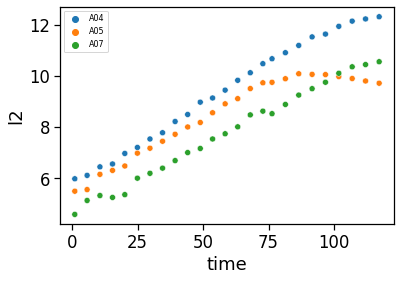

In [13]:
# dtp = data to plot
dtp = d[(d["well"] == "A04") | (d["well"] == "A05") | (d["well"] == "A07")]
sns.scatterplot(data=dtp, x="time", y="l2", hue="well")
plt.legend(loc='upper left', fontsize='8')

## Assignment task #2
Generate a scatterplot of population doublings over time for the same wells as the block above (wells A04, A05 and A07). Describe the difference you see between the new graph and the graph of data in log2 scale.

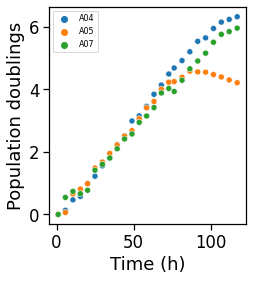

In [14]:
# dtp = data to plot
if IN_COLAB:
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
else:
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4), layout="constrained")
plt.subplot(133)
plt.xlabel('Time (h)')
plt.ylabel('Population doublings')
dtp = d[(d["well"] == "A04") | (d["well"] == "A05") | (d["well"] == "A07")]
sns.scatterplot(data=dtp, x="time", y="pd", hue="well")
plt.legend(loc='upper left', fontsize='8')


The population doubling graph and the log2 graph look generally similar. Wells A04 and A07 appear to have more similar trends in the population doubling graph compared to the log2 graph. Well A05 appears to have a more significant plateau in the population doubling graph than the log2 graph. 


Apart from visually inspecting the data, we should use model fitting to extract parameter values that can help us interpret the data quantitatively.

## Model fitting
### Use SciPy's `linregress` function or Seaborn's `lmplot` function
Because an exponential growth rate is directly proportional to the log of the number of components (i.e., cells), we can fit each well of data independently with a linear model to help interpret the data. Linear models are easy to fit and fitting functions are commonly provided by many different Python packages. We will find optimum parameters using two different packages: [`scipy.stats.lingress`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) and [`seaborn.lmplot`](). You can learn more about these algorithms by clicking on their names to get a link to online documentation.


In [15]:
from scipy.stats import linregress

Let's fit only the control data (`drug1.conc` == 0)

In [16]:
# dtf = data to fit
dtf = d[d["drug1.conc"]==0]
ctrl_wells = dtf["well"].unique()

We will perform a list comprehension to fit data for each well independently.

In [17]:
res = [linregress(dtf[dtf["well"]==ctrl_wells[i]][["time","l2"]]) for i in np.arange(len(ctrl_wells))]

The `linregress` function returns a `namedtuple` of length 5. Let's look at an example output.

In [18]:
example_well = dtf["well"].unique()[1]
print(f"Example linregress output for well {example_well}")
res[1]

Example linregress output for well A03


LinregressResult(slope=0.060846424497371744, intercept=5.212788495165553, rvalue=0.9990947611147231, pvalue=4.776167619926461e-33, stderr=0.0005402101680293283, intercept_stderr=0.036687154857080205)

Each value can be pulled out independently using the respective names. We will pull out all `slope` values, which represent the population doubling (proliferation) rate. To make it a bit easier to read we will also round the values to 4 decimal places.

In [19]:
prates = pd.Series(data=[np.round(r.slope,4) for r in res], index=ctrl_wells)
prates

A02    0.0602
A03    0.0608
A04    0.0596
A05    0.0421
A06    0.0632
A07    0.0528
A08    0.0612
A09    0.0515
A10    0.0592
A11    0.0557
dtype: float64

Most values are above 0.05 and most are close to 0.06, but one value looks low (A05: 0.0421). We can check for goodness of fit for linear regression by calculating $R^2$. (Only `rvalue` is provided, so we need to square it using `**2`.)

In [20]:
r2_vals = pd.Series(data=[np.round(r.rvalue**2,4) for r in res], index=ctrl_wells)
r2_vals

A02    0.9940
A03    0.9982
A04    0.9916
A05    0.8989
A06    0.9976
A07    0.9948
A08    0.9951
A09    0.9906
A10    0.9963
A11    0.9961
dtype: float64

Only well A05 has an $R^2$ value < 0.99.

So, 9 of 10 control wells are explained well by linear models. This fits with the visual evidence that something anomalous happens to the cell counts in well A05 after ~75. This is consistent with a possible technical problem when medium is changed in the experiment @ ~ 72h.  

## Assignment task #3
Perform linear regression using the `linregress` function on the trametinib-treated wells. Describe how the proliferation rates compare to the rates of the control wells in the subsequent markdown block.

In [21]:

dtf = d[d["drug1.conc"]>0]
treated_wells = dtf["well"].unique()
res = [linregress(dtf[dtf["well"]==treated_wells[i]][["time","l2"]]) for i in np.arange(len(treated_wells))]
prates = pd.Series(data=[np.round(r.slope,4) for r in res], index=treated_wells)
prates



 



A01    0.0013
A12    0.0018
dtype: float64

The rates for drug-treated cells were much lower than control treated cells. This suggests that drug treatment inhibits cell growth. 


We will visualize the linear model fitting using the seaborn `lmplot` function, which uses SciPy `linregress` function itself. This is a simple way to visualize the fits and their confidence intervals.

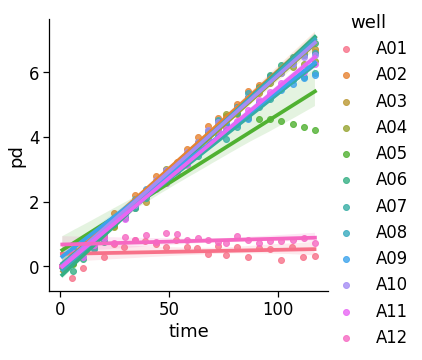

In [22]:
p = sns.lmplot(data=d, x="time", y="pd", hue="well")

We can also get fit parameter values from models fitting to all data from each condition (control or trametinib-treated).

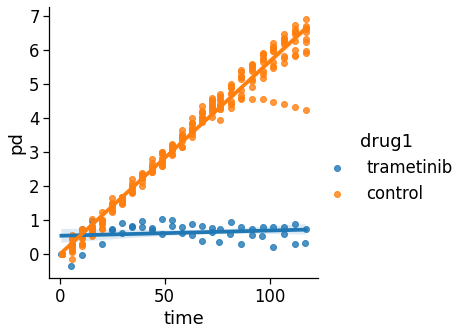

In [23]:
p = sns.lmplot(data=d, x="time", y="pd", hue="drug1")

## Non-loglinear data
When cells are in conditions that limit their proliferation or increase cell death, such as when contact inhibited or treated with drugs, their growth may appear nonlinear. To analyze data like this we can interpret the data using nonlinear model fitting. For this exercise we will use simulated data. 

In [24]:
np.random.seed(7)
times_by3 = np.arange(0,126,3)
mycounts = mylogistic(t=times_by3, P0=100, rate=0.06, K=1000)
sim_data = pd.DataFrame.from_dict({"time":times_by3,"cell.count":flatten_matrix([np.random.normal(x,0.05*x,1) for x in mycounts])})
sim_data["pd"] = np.log2(sim_data["cell.count"]/sim_data["cell.count"][0])
sim_data.head()

,time,cell.count,pd
0,0,108.452629,0.000000
1,3,114.671082,0.080437
2,6,137.605309,0.343471
3,9,163.397796,0.591324
4,12,178.516048,0.718989


<AxesSubplot:xlabel='time', ylabel='pd'>

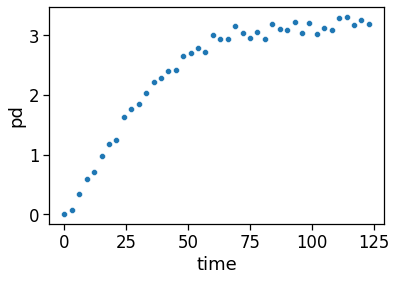

In [25]:
sns.scatterplot(data=sim_data, x="time", y="pd")

## Nonlinear model fitting with SciPy's `curve_fit` function
Nonlinear model fitting is more complicated and there aremany ways that optimal parameter values can be found. There is an entire field of research around parameter optimization! We will use a specific method employed by SciPy (the [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function) that has the objective to minimize the sum of the squared residuals of model to data.  It returns optimized coefficient values (`popt`) and the estimated covariance of `popt`. The diagonals provide the variance of the parameter estimates. To compute one standard deviation of parameter errors, we will use `perr = np.sqrt(np.diag(pcov))`.  

This approach to identify optimal parameter values is referred to as least squares regression and attempts to minimize the function 
$\sum_i(f(x_i,\beta)-y_i)^2$


In [26]:
from scipy.optimize import curve_fit

The function `{0:.4g}".format(x)` is for limiting the number of digits of the calculated values (making viewing the values easier).

In [27]:
logistic_popt, logistic_pcov = curve_fit(mylogistic, sim_data["time"], sim_data["cell.count"])
logistic_popt_str = ["{0:.4g}".format(x) for x in logistic_popt]


Printing the optimal parameter values.

In [28]:
print(f"Optimal parameter values for P0: {logistic_popt_str[0]}, rate: {logistic_popt_str[1]}, and K: {logistic_popt_str[2]}\n")

Optimal parameter values for P0: 100.3, rate: 0.05983, and K: 994



### Plot the data and overlay the model fit
To visualize on the plot we must convert to normalized log2 scale. We will also include a linear model fit for comparison (standard output of seaborn's `regplot`.

<AxesSubplot:xlabel='time', ylabel='pd'>

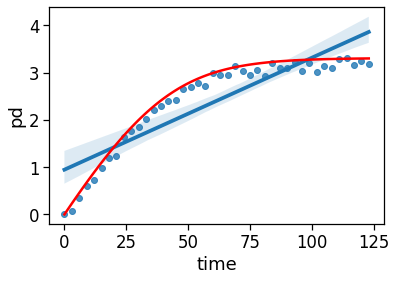

In [29]:
x_pred = np.linspace(min(times_by3),max(times_by3),100)
y_pred = mylogistic(x_pred, *logistic_popt)
y_pred = np.log2(y_pred/y_pred[0])
sns.regplot(x="time", y="pd", data=sim_data)
sns.lineplot(x=x_pred, 
             y=y_pred, 
             color="red")

Do the same for a Gompertz model.

In [30]:
gompertz_popt, gompertz_pcov = curve_fit(gompertz, sim_data["time"], sim_data["cell.count"])
gompertz_popt_str = ["{0:.4g}".format(x) for x in gompertz_popt]


In [31]:
print(f"Optimal parameter values for P0: {gompertz_popt_str[0]}, rate: {gompertz_popt_str[1]}, and K: {gompertz_popt_str[2]}\n")

Optimal parameter values for P0: 61.38, rate: 0.03833, and K: 1037



<AxesSubplot:xlabel='time', ylabel='pd'>

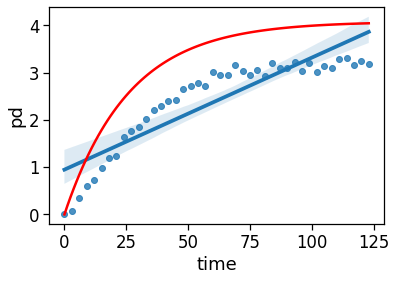

In [32]:
x_pred = np.linspace(min(times_by3),max(times_by3),100)
y_pred = gompertz(x_pred, *gompertz_popt)
y_pred = np.log2(y_pred/y_pred[0])
sns.regplot(x="time", y="pd", data=sim_data)
sns.lineplot(x=x_pred, 
             y=y_pred, 
             color="red")

### Limitations of these nonlinear growth models
#### Both logistic and Gompertz models:  
* Are phenomenological (they describe the result, not the cause)
* Use a carrying capacity parameter ($K$); this may be relevant to space available in a culture well and/or average cell size, but how would you interpret different values in response to drug?  

#### Gompertzian model:
* Has initial assumptions that do not correspond to a stable, exponentially dividing population (infinite rate at time=0, rate is continually changing)


## Assignment task (extra credit)
### How many days would it take for a single tumor cell to grow to a tumor the size of an egg?


**Assumptions:**
* There are ~ $10^9$ tumor cells  in 1 cm$^3$ (~1 g)
* Tumor Cell ≈ 1ng
* Egg ≈ 35g
* Average time per division (doubling time) ≈ 18h
* Doubling rate = 1/doubling time
* Population doubling equation: $P(t) = P_02^{rate*t}$


<table>
    <tr>
        <td>
        <img src="https://github.com/VU-CSP/quantbio-assignments/blob/main/img/cell_division.png?raw=1" style="width: 150px;" align="middle" /> 
        <td>
            $\Longrightarrow$ $\Longrightarrow$
        <td>
            <img src="https://github.com/VU-CSP/quantbio-assignments/blob/main/img/tumor.png?raw=1" style="width: 150px;"  align="middle" />
    </tr>
</table>



_Try to write a function that calculates this. Start of function definition is provided in code block below._  
NOTE: to calculate log2, use the numpy function `np.log2()`  
NOTE: check the units!

In [33]:
def timeToEgg(P0, egg, DT):
    '''
    P0=initial cell number
    egg=number of tumor cells in an egg-size tumor
    DT=time to double the population size (i.e., the average cell cycle time)
    '''
    # add your code for the function here
    return()

### Calculate time to egg-sized tumor from 100 cells
Do the calculation using the function you made.


In [34]:
# Execute your function with the correct input argument values.
# timeToEgg(P0=100,egg=<egg_val>,DT=<DT_val>)
